## 02 Reproduction with Authors' Code

written by **Jinwoo Lee**.    
jil527@ucsd.edu | jinwoo-lee.com

Nov 11th, 2025.    
as a PSYC201A's **Reproducibility Project**     

**Note:** This script aims to reproduce the following result with the authors' original code and data.      
> Mantel tests revealed that the (young adults’) left amygdala–ventral PFC tract-morphology dissimilarity matrix was significantly correlated with the trait-anxiety dissimilarity matrix (*P* = 0.036).

This notebook assumes that you have already obtained the data from the authors and placed them in the appropriate directories as specified in the README file. The original code is available at: https://github.com/humaffectneurolab/MorphSim_TraitAnxiety/blob/main/morphsim.R. 

---
### Step 1. Loading the Packages
I could not install the following packages in pixi-based environment, but they are not required for the reproduction analysis: `semPlot`, `nFactors`, and `Rtsne`.

In [13]:
library(parameters)
library(tidyverse)
library(psych)
library(see)
library(lavaan)
library(performance)
#library(semPlot)     # install error in pixi add r-
#library(nFactors)    # install error in pixi add r-
library(vegan)
library(jsonlite)
#library(Rtsne)       # install error in pixi add r-
library(ggplot2)
library(reshape)      # not included in the original code but needed for visualization

---
### Step 2. Constructing an Anxiety Distance Matrix

The authors selected a total of **119** participants for the **youth** group based on the following three criteria, and used them for analysis:     

- **Age:** 153 participants aged between 20 and 35 were initially selected.      

- **Availability of MRI data:** Of the 7 participants without diffusion MRI data, 3 fell within the above age range and were excluded, leaving a total of 150 participants.        

- **Presence of psychiatric disorders:** Among these, only 119 participants with no current or past diagnosis of psychiatric disorders were retained.    

Subsequently, using their STAI-G-X2 scores, the authors constructed a 119×119 distance matrix named `HAnnaKSTAI` by calculating the mean STAI score for all possible pairs of participants.

In [4]:
meta = read.csv("../data-from-authors/Meta.csv")
STAI = read.csv("../data-from-authors/STAI_G_X2.csv")

# filtering by age
youth = subset(meta, Age == "20-25" | Age == "25-30" | Age == "30-35")

# filtering by availability of MRI data
youth = subset(youth, X != "sub-032339" & X != "sub-032341" & X != "sub-032459" & X != "sub-032370"
               & X != "sub-032466" & X != "sub-032438" & X != "sub-032509")

# filtering by SKID diagnoses
youth$SKID_Diagnoses = as.factor(youth$SKID_Diagnoses)
youth$SKID_Diagnoses = as.numeric(youth$SKID_Diagnoses)
Hyouth = subset(youth, SKID_Diagnoses == 1 | SKID_Diagnoses == 10)

# leaving only relevant info
Hyouth = Hyouth[, -c(4:14, 16:21)]

# merging STAI data
Hyouth = merge(Hyouth, STAI, by = "X")

# constructing the anxiety distance matrix
HAnnaKSTAI = data.frame()
for (i in 1:119) {
  for (j in 1:119) {
    HAnnaKSTAI[j, i] = (sum(Hyouth[i, 5], Hyouth[j, 5]))/2
  }
}

---
### Step 3. Constructing a Brain Distance Matrix

The authors computed a one-dimensional vector representing each participant’s left vPFC–amygdala morphology using voxel-level streamline count features that had been preprocessed with a **5%** slice-level thresholding procedure (see Fig 1A in the original paper). For participants in the young group, the corresponding data are labeled as `yh_prob_5p_L`, which were subsequently loaded for analysis. Finally, this dataframe will be converted into the distance matrix `HAnnaKBrain` and used for the AnnaK model testing.



In [21]:
yh_prob_5p_L = read.csv("../data-from-authors/tractfiles/yh_probmap_5p_L.csv", header = T)
yh_prob_5p_L = yh_prob_5p_L[,-1]  # removing the first column which is just the index

HAnnaKBrain = dist(t(yh_prob_5p_L))

---
### Step 4. Anna Karenina Testing

Using `vegan::mantel`, the Spearman correlation coefficient between the two distance matrices was estimated via 10,000 iterations of the Mantel permutation test. Since the original code did not fix a random seed, we arbitrarily set the seed to 42 for our analysis.

In [22]:
set.seed(42)
mantel(HAnnaKSTAI, HAnnaKBrain, method = "spearman", permutations = 10000)


Mantel statistic based on Spearman's rank correlation rho 

Call:
mantel(xdis = HAnnaKSTAI, ydis = HAnnaKBrain, method = "spearman",      permutations = 10000) 

Mantel statistic r: 0.1485 
      Significance: 0.041596 

Upper quantiles of permutations (null model):
  90%   95% 97.5%   99% 
0.109 0.140 0.169 0.196 
Permutation: free
Number of permutations: 10000


---
### Step 5. Bonus: Visualization
Although this procedure is not presented in the original code, I will perform the following visualizations to examine the data structure:

* 1) visualize the two distance matrices, `HAnnaKSTAI` and `HAnnaKBrain`, as heatmaps; and

* 2) extract the upper-triangular elements from each matrix, vectorize them, and plot a scatterplot to visualize the correlation between the two resulting vectors.

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


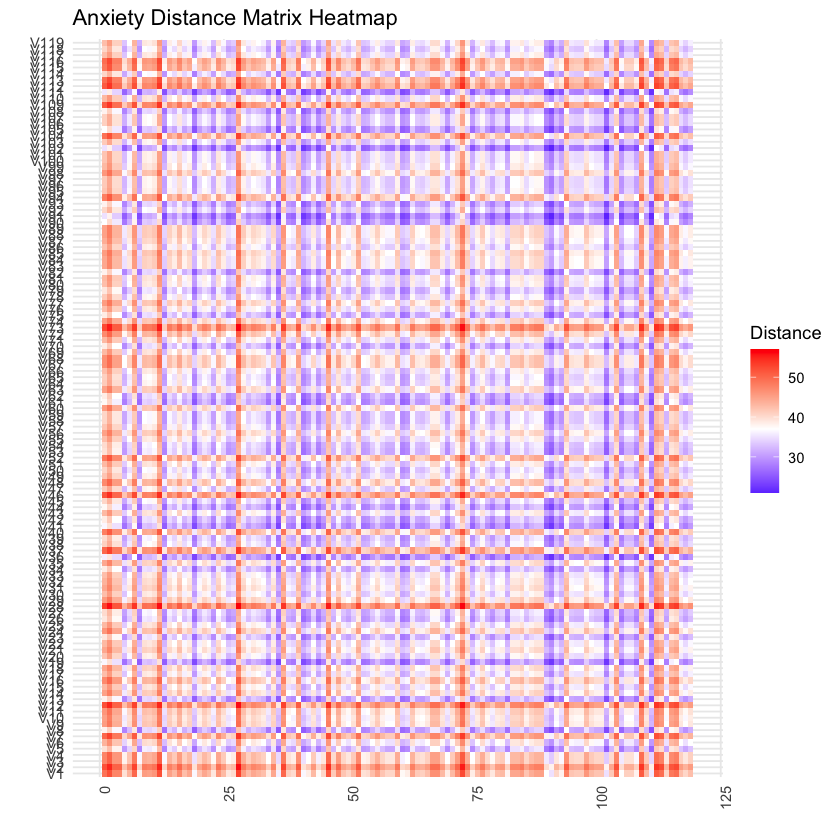

In [ ]:
# Visualizing the anxiety distance matrix
HAnnaKSTAI_melt <- melt(as.matrix(HAnnaKSTAI))

ggplot(HAnnaKSTAI_melt, aes(X1, X2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = median(HAnnaKSTAI_melt$value)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = "", y = "", fill = "Distance", title = "Anxiety Distance Matrix Heatmap")

Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”
Warning message in type.convert.default(X[[i]], ...):
“'as.is' should be specified by the caller; using TRUE”


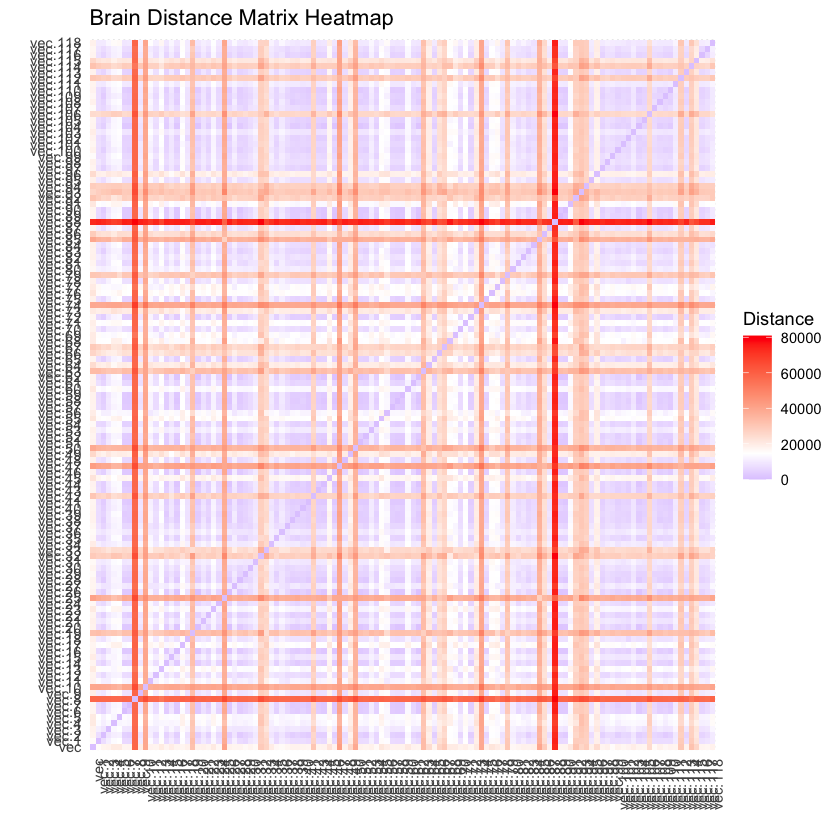

In [23]:
# Visualizing the anxiety distance matrix
HAnnaKBrain_melt <- melt(as.matrix(HAnnaKBrain))

ggplot(HAnnaKBrain_melt, aes(X1, X2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = median(HAnnaKBrain_melt$value)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(x = "", y = "", fill = "Distance", title = "Brain Distance Matrix Heatmap")

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 5310 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 5310 rows containing missing values or values outside the scale range
(`geom_point()`).”


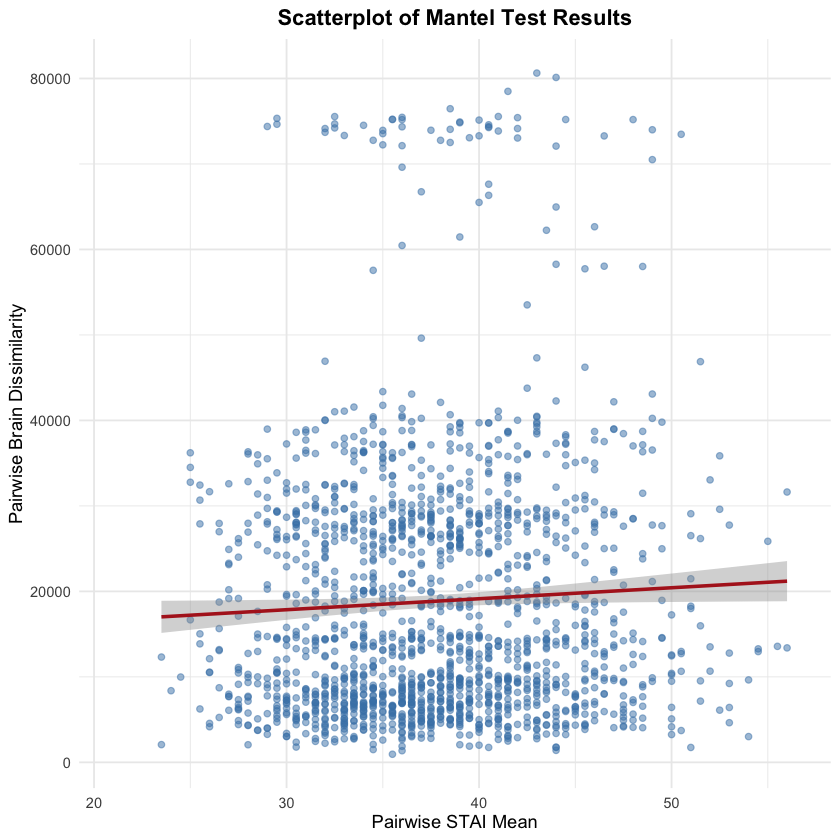

In [26]:
# Visualizing the scatterplot of pairwise STAI and Brain Dissimilarity
HAnnaKSTAI_vec <- HAnnaKSTAI[upper.tri(HAnnaKSTAI)]
HAnnaKBrain_vec <- HAnnaKBrain[upper.tri(HAnnaKBrain)]

total_df <- data.frame(stai_mean = HAnnaKSTAI_vec, brain_dissimilarity = HAnnaKBrain_vec)

ggplot(total_df, aes(x = stai_mean, y = brain_dissimilarity)) +
  geom_point(alpha = 0.5, color = "steelblue") +       
  geom_smooth(method = "lm", se = TRUE, color = "firebrick") + 
  theme_minimal() +
  labs(
    title = "Scatterplot of Mantel Test Results",
    x = "Pairwise STAI Mean",
    y = "Pairwise Brain Dissimilarity"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold")
  )